In [118]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initializedz
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [150]:
from scipy.stats import norm, uniform, pareto, expon, weibull_min
import numpy as np
import pandas as pd

# Process parameters
# σ^2 = 2Dt so the diffusion constants are D = 1/2 and D = 1/2 * (10)^(1/2)

sd = 1
n = 100


# Make the dataset by generating the displacements and then taking a cumulative sum to obtain the trajectories
def generate(batchsize=32,steps=n,sd=1):
    while True:
        # randomly choose a set of trajectory-length and final-time. This is intended
        # to increase variability in simuation conditions.
        x0 = x1 = uniform.rvs(scale = 50, size = (batchsize, 1))
        # label = pareto.rvs(b = 1, size = (batchsize,1))
        # label = expon.rvs(scale = 3, size = (batchsize, 1), loc = .1)
        # label = uniform.rvs(scale = 10, size = (batchsize, 1), loc = .1)
        label = weibull_min.rvs(c = .7, size = (batchsize,1), loc = .1)
        # weight = np.zeros(batchsize)
        xs = norm.rvs(size = (batchsize, steps-1), scale = sd)
        out = label * xs
        out = np.cumsum(np.concatenate((x0,out),axis=1), axis=1)
        label = label
        yield out, label ,[None]

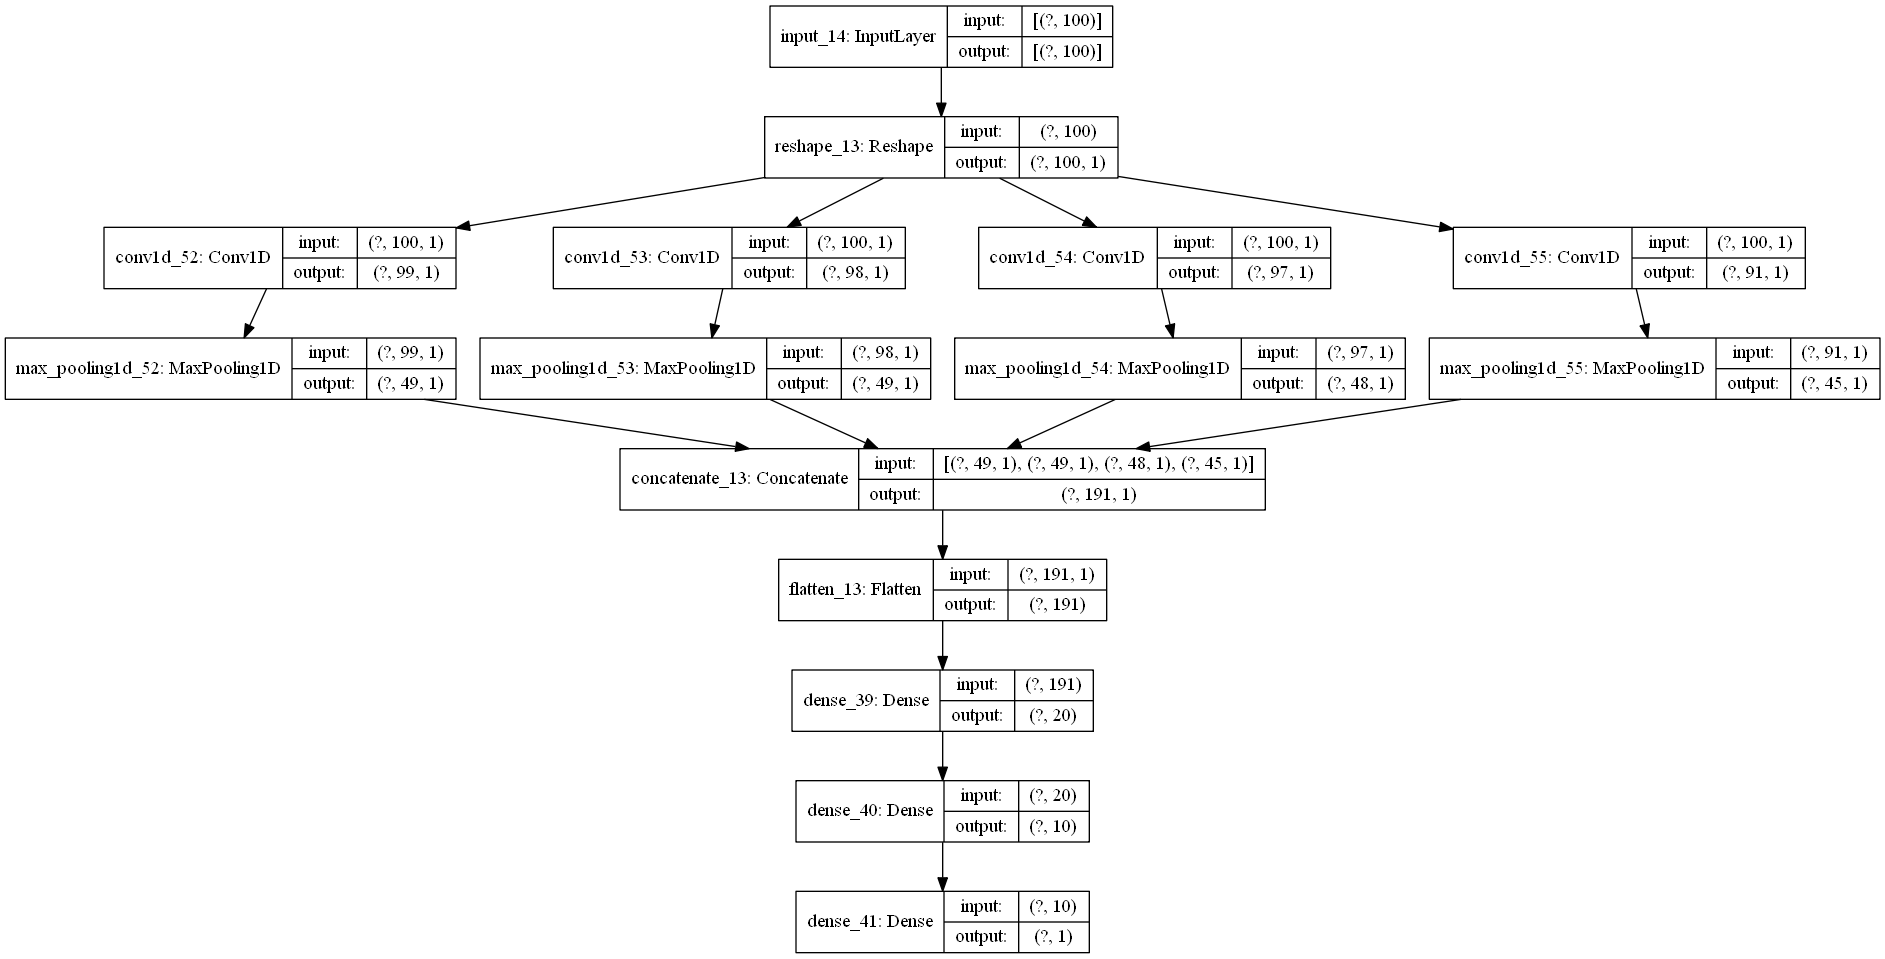

In [151]:
# Define the neural network model

from tensorflow import keras
# from functools import partial


def leaky_relu(x):
    return tf.nn.leaky_relu(x, alpha=0.01)

activation = 'elu'

input = keras.Input(shape = (n, ))
reshape = tf.keras.layers.Reshape(target_shape = (n, 1, ), input_shape=(n, ))(input)

conv1 = keras.layers.Conv1D(filters = 1, input_shape = (None, n, 1), kernel_size = 2, activation=activation)(reshape)
conv1 = keras.layers.MaxPooling1D(pool_size = 2)(conv1)

conv2 = keras.layers.Conv1D(filters = 1, input_shape = (None, n, 1), kernel_size = 3, activation=activation)(reshape)
conv2 = keras.layers.MaxPooling1D(pool_size = 2)(conv2)

conv3 = keras.layers.Conv1D(filters = 1, input_shape = (None, n, 1), kernel_size = 4, activation=activation)(reshape)
conv3 = keras.layers.MaxPooling1D(pool_size = 2)(conv3)

conv4 = keras.layers.Conv1D(filters = 1, input_shape = (None, n, 1), kernel_size = 10, activation=activation)(reshape)
conv4 = keras.layers.MaxPooling1D(pool_size = 2)(conv4)

x = keras.layers.Concatenate(axis = 1)(inputs = [conv1, conv2, conv3, conv4])
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(20, activation=activation)(x)
x = keras.layers.Dense(10, activation=activation)(x)
x = keras.layers.Dense(1, activation=activation)(x)

model = keras.Model(inputs=input, outputs=x, name="diffusion")
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

In [152]:
model.summary()

Model: "diffusion"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
reshape_13 (Reshape)            (None, 100, 1)       0           input_14[0][0]                   
__________________________________________________________________________________________________
conv1d_52 (Conv1D)              (None, 99, 1)        3           reshape_13[0][0]                 
__________________________________________________________________________________________________
conv1d_53 (Conv1D)              (None, 98, 1)        4           reshape_13[0][0]                 
__________________________________________________________________________________________

In [156]:
model.compile(
    optimizer = 'adam',
#     loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['MeanAbsolutePercentageError']
)

In [157]:
# model.get_weights()

In [ ]:
# Tensorboard can be used to view several aspects of the trained model. Using it in a Jupyter notebook is not recommended, since the output is small on screen. 
# %load_ext tensorboard

# # Clear any logs from previous runs
# !rm -rf ./logs/ # CHECK IF NOTHING IMPORTANT IS HERE

# import datetime
# log_dir = "logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 100)
mc = keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_MeanAbsolutePercentageError', mode='min', verbose=0, save_best_only=True)
# lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_lr=1e-9)

history = model.fit(
    generate(batchsize = 1000),
    steps_per_epoch = 30,
    validation_data = generate(batchsize = 1000),
    validation_steps =10,
    callbacks = [mc, es], #tensorboard_callback
    epochs = 4000,
    verbose = 2
#     callbacks=[tensorboard_callback]
)

Train for 30 steps, validate for 10 steps
Epoch 1/4000
30/30 - 2s - loss: 96.2465 - MeanAbsolutePercentageError: 44.6669 - val_loss: 74.4105 - val_MeanAbsolutePercentageError: 38.4116
Epoch 2/4000
30/30 - 0s - loss: 73.3500 - MeanAbsolutePercentageError: 32.5588 - val_loss: 97.6999 - val_MeanAbsolutePercentageError: 25.9964
Epoch 3/4000
30/30 - 1s - loss: 144.8273 - MeanAbsolutePercentageError: 32.4407 - val_loss: 75.6142 - val_MeanAbsolutePercentageError: 51.9882
Epoch 4/4000
30/30 - 0s - loss: 77.2019 - MeanAbsolutePercentageError: 68.9832 - val_loss: 60.4115 - val_MeanAbsolutePercentageError: 59.2952
Epoch 5/4000
30/30 - 0s - loss: 75.3939 - MeanAbsolutePercentageError: 60.3141 - val_loss: 120.9127 - val_MeanAbsolutePercentageError: 67.3800
Epoch 6/4000
30/30 - 0s - loss: 86.4048 - MeanAbsolutePercentageError: 96.7197 - val_loss: 55.9029 - val_MeanAbsolutePercentageError: 140.7347
Epoch 7/4000
30/30 - 0s - loss: 77.1102 - MeanAbsolutePercentageError: 118.3355 - val_loss: 56.7171 - v

In [ ]:
# For an in browser view in a seperate tab go to localhost:PORT_NUMBER, typically localhost:6006
# %tensorboard --logdir logs/fit

In [ ]:
test, values, _ = next(generate(batchsize = 10**4))

model = keras.models.load_model('best_model.h5')
model.evaluate(test,values)


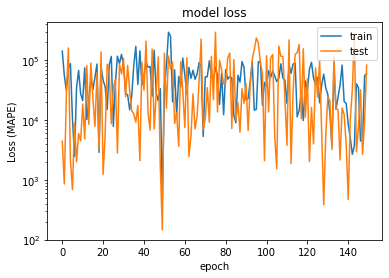

In [114]:
from matplotlib import pyplot as plt

# summarize history for loss
plt.plot(history.history['MeanAbsolutePercentageError'])
plt.plot(history.history['val_MeanAbsolutePercentageError'])
plt.title('model loss')
plt.ylabel('Loss (MAPE)')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('fastslowgenerated_learningcurve.pdf')

In [115]:
# Print the names, sizes and layer index of the convolutional layers
for number, layer in enumerate(model.layers):
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape, " on layer: ", number)

conv1d_36 (2, 1, 1)  on layer:  2
conv1d_37 (3, 1, 1)  on layer:  3
conv1d_38 (4, 1, 1)  on layer:  4
conv1d_39 (10, 1, 1)  on layer:  5


In [116]:
# retrieve filter weights from the second hidden layer
filters, biases = model.layers[2].get_weights()
print(filters)

[[[ 0.14180516]]

 [[-0.10358729]]]


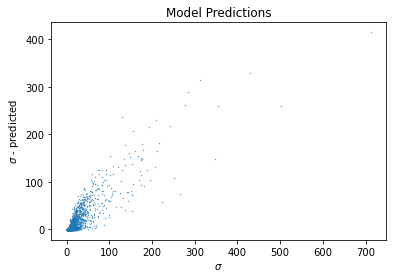

In [117]:
# Plot model predictions for all trajectories in the dataset

predictions = model.predict(test)
plt.scatter(
    y = predictions,
    x = values,
    s = .1
)
# plt.legend(loc = 'upper right')
plt.title('Model Predictions')
plt.xlabel('$\sigma$')
plt.ylabel('$\sigma$ - predicted')
# plt.xlim(0,2)
# plt.ylim(0,2)
plt.savefig('fastslowgenerated_predictions.pdf')

In [145]:
np.diff(test[1])

array([-1.00807401e-01, -2.31538902e-01,  3.00451971e-01, -2.79875102e-01,
       -3.14831167e-02, -8.63916286e-02,  1.08472481e-02,  7.35101054e-02,
       -2.86402608e-01, -1.00925491e-01, -3.54435053e-02,  1.48074201e-01,
       -2.55428423e-01,  3.85155863e-02,  5.45852456e-02,  3.70210771e-02,
        1.38124208e-01,  5.62970811e-02, -1.13959421e-01,  1.30246328e-01,
       -2.94792120e-01, -9.51255159e-02, -2.12769022e-01, -2.04882687e-02,
        9.46212081e-02,  1.47942962e-01, -3.55847946e-02,  2.24019101e-02,
        4.60679573e-02,  1.37568836e-01,  1.47080524e-01,  3.67737030e-02,
       -1.85709615e-01,  8.74081115e-02,  1.61114878e-01, -1.22630381e-01,
        5.24694992e-02,  2.32279805e-01, -4.19231586e-02, -1.80107106e-02,
        3.70452938e-02,  9.98309903e-02, -7.06889226e-02,  8.03942976e-02,
       -1.23720488e-01,  8.76420488e-02, -2.08052639e-05, -3.03100196e-02,
       -9.06797166e-02,  8.06337587e-02, -6.20878834e-02,  1.59402300e-01,
       -1.18963180e-01,  

In [148]:
rmse = 0
for trajectory, sigma in zip(test, values):
    average = sum(np.diff(trajectory))/(n-1)
    sigmahat = np.sqrt(sum((np.diff(trajectory)-average*np.ones(99))**2)/(n-1))
    rmse += abs(sigmahat-sigma)/sigma
    
print(rmse/10**4)

[0.05829322]
